In [1]:
# Import necessary packages
import h5py
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from rio_cogeo.cogeo import cog_validate
import rasterio
from rasterio.plot import show
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
#Inspect source HDF5 files:
file = 'raw-data/IMERG/IMERG_test_data.HDF5'

# Open the HDF5 file and inspect its contents
with h5py.File(file, 'r') as f:

    #Extract needed variables:
    precipitation_data = f['Grid']['precipitation'][:]
    latitudes = f['Grid']['lat'][:]
    longitudes = f['Grid']['lon'][:]

In [3]:
print(f"Original shape of precipitation data: {precipitation_data.shape}")
precipitation_data = np.squeeze(precipitation_data)
print(f"Shape after squeezing: {precipitation_data.shape}")

Original shape of precipitation data: (1, 3600, 1800)
Shape after squeezing: (3600, 1800)


In [4]:
#Transpose precip data so lat/lon matches x/y that the array expects:
precipitation_data= precipitation_data.T

# Ensure the dtype is explicitly set (e.g., float32)
precipitation_data = precipitation_data.astype('float32')

# Mask the no-data values (-9999)
precipitation_data = np.ma.masked_equal(precipitation_data, -9999)

# Create an xarray DataArray from the precipitation data
xds = xr.DataArray(
    precipitation_data,
    dims=["y", "x"],
    coords={"y": latitudes, "x": longitudes},
    name="precipitation"
)

In [ ]:
#Ensure that the coordinates are on the correct grid:
xds = xds.assign_coords(longitudes=(((xds.x + 180) % 360) - 180)).sortby("x")

xds = xds.isel(y=slice(None, None, -1))

# Ensure the dataset has the proper spatial dimensions and CRS
xds.rio.set_spatial_dims("x", "y", inplace=True)
xds.rio.write_crs("EPSG:4326", inplace=True)
xds.rio.transform()

# Write the data to a COG file using rioxarray
cog_filename = "test_cog_IMERG.tif"
xds.rio.to_raster(
    cog_filename,
    driver="COG",
    dtype="float32",  # Set the dtype explicitly to avoid errors
    nodata=-9999      # Set the no-data value
)

In [ ]:
# Validate the COG file
cog_valid = cog_validate(cog_filename)
print(f"COG validation: {cog_valid}")

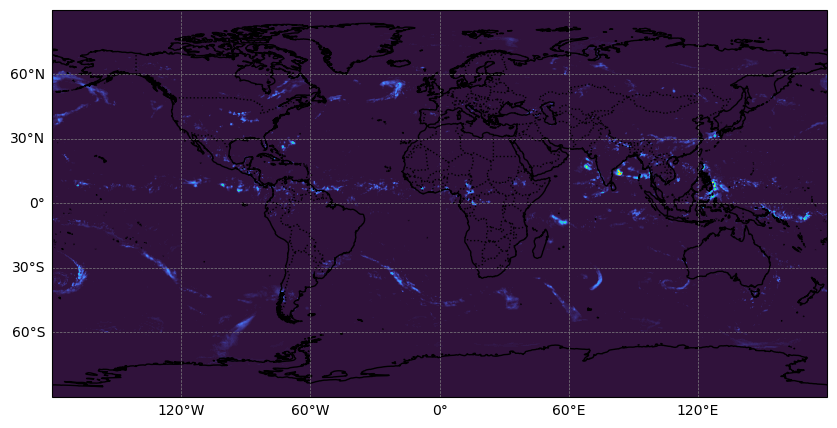

In [123]:
### Plot the transformed COG ###

# Path to the Cloud Optimized GeoTIFF (COG)
cog_filename = "test_cog_IMERG.tif"

# Open the COG file using rasterio
with rasterio.open(cog_filename) as src:
    # Set up the plot with Cartopy
    fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})
    
    # Plot the COG data using rasterio's show function
    show(src, ax=ax, cmap='turbo', vmin=0, vmax=50, transform=ccrs.PlateCarree())
    
    # Add Cartopy coastlines and borders for geographic reference
    ax.coastlines(resolution='50m', color='black', linewidth=1)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=1)
    
    # Add gridlines for reference
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', linestyle='--')
    gl.right_labels = False
    gl.top_labels = False

    # Show the plot
    plt.show()